# TensorFlow Workshop - Batch Normalization
2019/09/06

[ Reference ]
+ Rui Shu, "**TENSORFLOW GUIDE: BATCH NORMALIZATION**", 2016/12/26. http://ruishu.io/2016/12/27/batchnorm/
    + Github code: https://github.com/RuiShu/micro-projects/blob/master/tf-batchnorm/batchnorm_guide.ipynb
+ Antoine Labatie, "**It’s Necessary to Combine Batch Norm and Skip Connections**", Towards Data Science, 2019/09/01. https://towardsdatascience.com/its-necessary-to-combine-batch-norm-and-skip-connections-e92210ca04da
+ Federico Peccia, "**Batch normalization: theory and how to use it with Tensorflow**", , Towards Data Science, 2018/09/16. https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad

In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
# for the old-version usage of TensorFlow, such as tensorflow.examples.tutorials.mnist
old_v = tf.logging.get_verbosity()          
tf.logging.set_verbosity(tf.logging.ERROR) 

C:\Users\USER\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0


### Input MNIST dataset 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print(" mnist.train.images.shape :\t ", mnist.train.images.shape)
print(" mnist.train.labels.shape :\t ", mnist.train.labels.shape)
print(" mnist.validation.images.shape : ", mnist.validation.images.shape)
print(" mnist.validation.labels.shape : ", mnist.validation.labels.shape)
print(" mnist.test.images.shape :\t ", mnist.test.images.shape)
print(" mnist.test.labels.shape :\t ", mnist.test.labels.shape)

mnist.test.labels[0]

 mnist.train.images.shape :	  (55000, 784)
 mnist.train.labels.shape :	  (55000, 10)
 mnist.validation.images.shape :  (5000, 784)
 mnist.validation.labels.shape :  (5000, 10)
 mnist.test.images.shape :	  (10000, 784)
 mnist.test.labels.shape :	  (10000, 10)


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

> + **[NOTE]: the `phase` term. **
    + useed as a **placeholder for a boolean** which we will insert into ``feed_dict`. 
    + It will serve as a binary indicator for whether we are in **training phase=True** or **testing phase=False** mode. 

In [4]:
def train_test():
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    
    # --------------------------------------
    # Launch the computation graph...
    # --------------------------------------
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    history = []
    iterep = 500
    for i in range(iterep * 30):
        x_train, y_train = mnist.train.next_batch(100)
        sess.run(train_step,
                 feed_dict={'x:0': x_train, 
                            'y:0': y_train, 
                            'phase:0': 1})
        if (i + 1) %  iterep == 0:
            epoch = (i + 1)/iterep
            tr = sess.run([loss, accuracy], 
                          feed_dict={'x:0': mnist.train.images,
                                     'y:0': mnist.train.labels,
                                     'phase:0': 1})
            t = sess.run([loss, accuracy], 
                         feed_dict={'x:0': mnist.validation.images,
                                    'y:0': mnist.validation.labels,
                                    'phase:0': 0})
            history += [[epoch] + tr + t]
            print(history[-1])
            
    print("\n Computing the test accuracy ... ", end = " ")
    
    ##  ------------------------------------------------------------------
    ##  Test datasets...
    ##  ------------------------------------------------------------------
    test_loss = sess.run(loss, feed_dict={'x:0': mnist.test.images,
                                          'y:0': mnist.test.labels,
                                          'phase:0': 0})
    test_accu = sess.run(accuracy, feed_dict={'x:0': mnist.test.images,
                                              'y:0': mnist.test.labels,
                                              'phase:0': 0})
    print(" Done !!! ")
    
    return history, test_accu, test_loss

## < Case 1 > : No batch normalization

In [5]:
def dense(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, 
                                             activation_fn=None,
                                             scope=scope)

def dense_relu(x, size, scope):
    with tf.variable_scope(scope):
        h1 = dense(x, size, 'dense')
        return tf.nn.relu(h1, 'relu')

In [6]:
# Reset the default graph...
tf.reset_default_graph()

# -------------------------------
# Build a computation graph...
# -------------------------------
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

# FCDNetwork with 2 hidden layers...
h1 = dense_relu(x, 100, 'layer1')
h2 = dense_relu(h1, 100, 'layer2')
logits = dense(h2, 10, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [7]:
history, test_accu, test_loss = train_test()

[1.0, 0.64369357, 0.8404545, 0.63108987, 0.8424]
[2.0, 0.43187112, 0.8845636, 0.41367382, 0.8922]
[3.0, 0.3668733, 0.89634544, 0.34968525, 0.9064]
[4.0, 0.3330358, 0.9050909, 0.31499434, 0.9154]
[5.0, 0.3079033, 0.91243637, 0.29269007, 0.9228]
[6.0, 0.29071343, 0.91636366, 0.27582532, 0.9256]
[7.0, 0.27571824, 0.92103636, 0.26102918, 0.9304]
[8.0, 0.26239407, 0.92416364, 0.24881089, 0.932]
[9.0, 0.25016466, 0.9281818, 0.237745, 0.935]
[10.0, 0.24003498, 0.9311636, 0.22789778, 0.939]
[11.0, 0.22972186, 0.93456364, 0.21864599, 0.9406]
[12.0, 0.22152866, 0.93709093, 0.21245202, 0.9428]
[13.0, 0.213613, 0.9393091, 0.20563754, 0.9446]
[14.0, 0.20524722, 0.94183636, 0.19743003, 0.9444]
[15.0, 0.19854386, 0.94363636, 0.19187737, 0.947]
[16.0, 0.19190809, 0.9461273, 0.18588974, 0.9482]
[17.0, 0.18590873, 0.9474364, 0.18186072, 0.9492]
[18.0, 0.18064874, 0.9486727, 0.17720234, 0.9502]
[19.0, 0.1762649, 0.95001817, 0.17391694, 0.9514]
[20.0, 0.16990486, 0.9518909, 0.16850537, 0.9524]
[21.0, 0.16

In [8]:
print(" [ Test  Accuracy ] : {}".format(test_accu) +
      "\n [ Test Loss Score ] : {}".format(test_loss))

 [ Test  Accuracy ] : 0.9592000246047974
 [ Test Loss Score ] : 0.13954949378967285


## < Case 2 > : Standard batch normalization
+ Batch normalization would be to simply use the `tf.contrib.layers.batch_norm layer`.
+ One thing that might stand out is the `phase` term. 
    + We are going to use as a **placeholder for a boolean** which we will insert into feed_dict. 
    + It will serve as a binary indicator for whether we are in **training phase=True** or **testing phase=False** mode. 
    
    
+ Recall that batch normalization has distinct behaviors during training verus test time:
> + Training
    1. Normalize layer activations according to mini-batch statistics.
    2. During the training step, update population statistics approximation via moving average of mini-batch statistics.
 + Testing
    1. Normalize layer activations according to estimated population statistics.
    2. Do not update population statistics according to mini-batch statistcs from test data.

In [9]:
def dense_batch_relu(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, 100, activation_fn=None, scope='dense')
        
        # Batch normalization would be to simply use the tf.contrib.layers.batch_norm layer.
        h2 = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training = phase,
                                          scope='bn')
        return tf.nn.relu(h2, 'relu')

In [10]:
# Reset the default graph...
tf.reset_default_graph()

# -------------------------------
# Build a computation graph...
# -------------------------------
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

# FCDNetwork with 2 hidden layers...
h1 = dense_batch_relu(x, phase,'layer1')
h2 = dense_batch_relu(h1, phase, 'layer2')
logits = dense(h2, 10, 'logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [11]:
history_bn, test_accu_bn, test_loss_bn = train_test()

[1.0, 0.40485322, 0.8984727, 1.1999239, 0.874]
[2.0, 0.2847411, 0.9240909, 0.74184793, 0.9224]
[3.0, 0.23023732, 0.9374545, 0.45222998, 0.9382]
[4.0, 0.19694106, 0.9461273, 0.29963955, 0.946]
[5.0, 0.17364232, 0.9526, 0.22907026, 0.9512]
[6.0, 0.1556297, 0.95794547, 0.18720317, 0.9558]
[7.0, 0.14133391, 0.96154547, 0.16559318, 0.961]
[8.0, 0.12933636, 0.96492726, 0.14862578, 0.9628]
[9.0, 0.1194299, 0.96763635, 0.14128284, 0.9622]
[10.0, 0.110820666, 0.9699091, 0.13217904, 0.9628]
[11.0, 0.10316458, 0.9722546, 0.1249631, 0.967]
[12.0, 0.09651291, 0.9743818, 0.12111182, 0.9676]
[13.0, 0.090465836, 0.97621816, 0.116490304, 0.9666]
[14.0, 0.084837526, 0.9777455, 0.109915316, 0.9682]
[15.0, 0.07990484, 0.9793636, 0.10598856, 0.9698]
[16.0, 0.07566225, 0.9804909, 0.10386348, 0.9708]
[17.0, 0.071816705, 0.9815091, 0.100832835, 0.9726]
[18.0, 0.06806612, 0.98267275, 0.098630674, 0.9716]
[19.0, 0.06444315, 0.98407274, 0.09647686, 0.9728]
[20.0, 0.061162584, 0.98474544, 0.095267855, 0.9728]
[21

In [12]:
print(" << With Batch Normalization >> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_bn) +
      "\n [ Test Loss Score ] : {}".format(test_loss_bn))

print("\n < Without Batch Normalization > :")
print(" [ Test  Accuracy ] : {}".format(test_accu) +
      "\n [ Test Loss Score ] : {}".format(test_loss))

 << With Batch Normalization >> :
 [ Test  Accuracy ] : 0.9750000238418579
 [ Test Loss Score ] : 0.0813644602894783

 < Without Batch Normalization > :
 [ Test  Accuracy ] : 0.9592000246047974
 [ Test Loss Score ] : 0.13954949378967285


## < Case 3 > : Post-activation batch normalization

In [13]:
def dense_relu_batch(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = dense_relu(x, 100, scope='dense_relu')
        
        ##  Post-activation batch normalization...
        bn = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
        return bn

In [14]:
tf.reset_default_graph()
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

h1 = dense_relu_batch(x, phase,'layer1')
h2 = dense_relu_batch(h1, phase, 'layer2')
logits = dense(h2, 10, 'logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [15]:
history_post_bn, test_accu_post_bn, test_loss_post_bn = train_test()

[1.0, 0.29338053, 0.9196909, 1.272942, 0.8548]
[2.0, 0.21475086, 0.94027275, 0.85041726, 0.9034]
[3.0, 0.17784858, 0.9508, 0.5474856, 0.9302]
[4.0, 0.15348966, 0.9576182, 0.33674404, 0.948]
[5.0, 0.13592385, 0.96212727, 0.23857275, 0.9506]
[6.0, 0.12175672, 0.9664364, 0.18252197, 0.9586]
[7.0, 0.11116396, 0.96958184, 0.15072505, 0.9634]
[8.0, 0.102125496, 0.97203636, 0.13410223, 0.9644]
[9.0, 0.094353765, 0.9739091, 0.123353615, 0.9652]
[10.0, 0.08762966, 0.97603637, 0.11615393, 0.9656]
[11.0, 0.08140675, 0.97761816, 0.11205431, 0.9684]
[12.0, 0.076269366, 0.9791273, 0.1095569, 0.9678]
[13.0, 0.07150714, 0.9804909, 0.10551389, 0.967]
[14.0, 0.067102194, 0.98196363, 0.102774344, 0.9674]
[15.0, 0.062983826, 0.9833818, 0.0987692, 0.9686]
[16.0, 0.059224024, 0.98425454, 0.09673692, 0.9696]
[17.0, 0.055802558, 0.9854364, 0.095744595, 0.9712]
[18.0, 0.052325185, 0.98661816, 0.09365685, 0.9706]
[19.0, 0.049617745, 0.9872364, 0.09164633, 0.9716]
[20.0, 0.046990424, 0.98865455, 0.09050287, 0.97

In [16]:
print(" <<< Post-activation Batch Normalization >>> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_post_bn) +
      "\n [ Test Loss Score ] : {}".format(test_loss_post_bn))

print(" << With Batch Normalization >> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_bn) +
      "\n [ Test Loss Score ] : {}".format(test_loss_bn))

print("\n < Without Batch Normalization > :")
print(" [ Test  Accuracy ] : {}".format(test_accu) +
      "\n [ Test Loss Score ] : {}".format(test_loss))

 <<< Post-activation Batch Normalization >>> :
 [ Test  Accuracy ] : 0.9761000275611877
 [ Test Loss Score ] : 0.08165952563285828
 << With Batch Normalization >> :
 [ Test  Accuracy ] : 0.9750000238418579
 [ Test Loss Score ] : 0.0813644602894783

 < Without Batch Normalization > :
 [ Test  Accuracy ] : 0.9592000246047974
 [ Test Loss Score ] : 0.13954949378967285


## Evaluation

In [17]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [18]:
history = np.array(history)
history_bn = np.array(history_bn)
history_post_bn = np.array(history_post_bn)

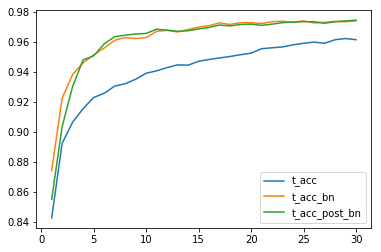

In [19]:
plt.plot(history[:, 0], history[:, -1], label='t_acc')
plt.plot(history_bn[:, 0], history_bn[:, -1], label='t_acc_bn')
plt.plot(history_post_bn[:, 0], history_post_bn[:, -1], label='t_acc_post_bn')
plt.legend()

### As you can see, batch normalization really does help with training (not always, but it certainly did in this simple example).